# 0. Install Pytorch
<hr>

In [ ]:
!pip install torch==1.2.0 torchvision==0.4.0

In [ ]:
!pip install pillow==6.2.1

# 1. Setting
<hr>

import library

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Tue Nov 17 03:48:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    13W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+

In [61]:
# import library
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from pandas import Series, DataFrame
import pandas as pd

torch.__version__

# using gpu 
use_cuda = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda


# 2. Data
<hr>

load data & apply normalization


In [ ]:
from torchvision import transforms, datasets


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 3. Model
<hr>

- design a neural network that consists of three fully connected layers with an activation function of Sigmoid

- the activation function for the output layer is LogSoftmax

In [ ]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        inputs = inputs.to(device)
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


# 4. Loss Function
<hr>

In [ ]:
# Test
model = classification().to(device)
criterion = nn.NLLLoss()
train_y_pred = model(training_set.data.float())
train_y = training_set.targets.to(device)
loss = criterion(train_y_pred, train_y)
print(loss)


tensor(2.3352, device='cuda:0', grad_fn=<NllLossBackward>)


# 5. Optimization
<hr>

In [ ]:
def gradient_descent(data_set, batch_size, 
                     learning_rate_value, num_epochs) :

  # classifier
  model = classification().to(device)

  # optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_value)

  # loss function
  criterion = nn.NLLLoss()

  # batching
  data_loader =  torch.utils.data.DataLoader(
      data_set,
      batch_size=batch_size,
      shuffle=True)

  # return variables
  loss_list, acc_list = [], []


  # training
  for epoch in range(num_epochs):

    loss_sum = 0
    acc_sum = 0
    iteration = 0

    for xs, ts in iter(data_loader):
        
        if len(ts) != batch_size:
          continue
        
        y_pred = model(xs.to(device))
        loss = criterion(y_pred, ts.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iteration = iteration + 1
        loss_sum = loss_sum + float(loss)
        zs = y_pred.max(1, keepdim=True)[1]  # get the index of the max logit
        ts = ts.to(device)
        acc_sum = acc_sum + zs.eq(ts.view_as(zs)).sum().item() / int(ts.shape[0])

    loss_avg = math.trunc((loss_sum/iteration) * 1000) / 1000
    acc_avg = math.trunc((acc_sum/iteration) * 1000) / 1000
    loss_list.append(loss_avg)
    acc_list.append(acc_avg)
    
    if iteration == 0 or epoch % 20 != 0:
      continue

    print("epoch : ", epoch, " --------------------------------- ")
    print("loss : ", loss_avg)
    print("accuracy : ", acc_avg)

  return loss_list, acc_list 

# 6. run gradient descent with different mini-batches sizes
<hr>

In [ ]:
batch_sizes = [32, 64, 128]
training_loss_list, training_acc_list = [[], [], []], [[], [] ,[]]
testing_loss_list, testing_acc_list = [[], [], []], [[], [] ,[]]

In [ ]:
# Training Data Batch Size 32
print("=================== batch size is 32 ===================")
loss_list, acc_list = gradient_descent(training_set, 32, 0.015, 200)
training_loss_list[0] = loss_list
training_acc_list[0] = acc_list

=================== batch size is 32 ===================
epoch :  0  --------------------------------- 
loss :  1.964
accuracy :  0.41
epoch :  20  --------------------------------- 
loss :  0.143
accuracy :  0.959
epoch :  40  --------------------------------- 
loss :  0.068
accuracy :  0.981
epoch :  60  --------------------------------- 
loss :  0.037
accuracy :  0.991
epoch :  80  --------------------------------- 
loss :  0.02
accuracy :  0.996
epoch :  100  --------------------------------- 
loss :  0.012
accuracy :  0.998
epoch :  120  --------------------------------- 
loss :  0.008
accuracy :  0.999
epoch :  140  --------------------------------- 
loss :  0.005
accuracy :  0.999
epoch :  160  --------------------------------- 
loss :  0.004
accuracy :  0.999
epoch :  180  --------------------------------- 
loss :  0.003
accuracy :  0.999


In [ ]:
# Testing Data Batch Size 32
print("=================== batch size is 32 ===================")
loss_list, acc_list = gradient_descent(testing_set, 32, 0.015, 200)
testing_loss_list[0] = loss_list
testing_acc_list[0] = acc_list

=================== batch size is 32 ===================
epoch :  0  --------------------------------- 
loss :  2.29
accuracy :  0.14
epoch :  20  --------------------------------- 
loss :  0.368
accuracy :  0.899
epoch :  40  --------------------------------- 
loss :  0.241
accuracy :  0.931
epoch :  60  --------------------------------- 
loss :  0.177
accuracy :  0.949
epoch :  80  --------------------------------- 
loss :  0.133
accuracy :  0.964
epoch :  100  --------------------------------- 
loss :  0.1
accuracy :  0.974
epoch :  120  --------------------------------- 
loss :  0.075
accuracy :  0.982
epoch :  140  --------------------------------- 
loss :  0.056
accuracy :  0.988
epoch :  160  --------------------------------- 
loss :  0.042
accuracy :  0.991
epoch :  180  --------------------------------- 
loss :  0.031
accuracy :  0.995


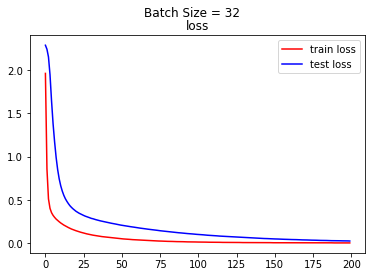

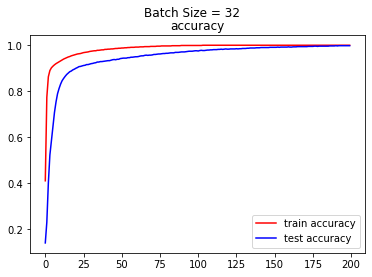

In [ ]:
# Plot Batch Size 32
plt.suptitle("Batch Size = {}".format(batch_sizes[0]))
plt.title("loss")
plt.plot(training_loss_list[0], c = 'red', label = 'train loss')
plt.plot(testing_loss_list[0], c = 'blue', label = 'test loss')
plt.legend(loc = 'upper right')
plt.show()

plt.suptitle("Batch Size = {}".format(batch_sizes[0]))
plt.title("accuracy")
plt.plot(training_acc_list[0], c = 'red', label = 'train accuracy')
plt.plot(testing_acc_list[0], c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# Training Data Batch Size 64
print("=================== batch size is 64 ===================")
loss_list, acc_list = gradient_descent(training_set, 64, 0.015, 200)
training_loss_list[1] = loss_list
training_acc_list[1] = acc_list

=================== batch size is 64 ===================
epoch :  0  --------------------------------- 
loss :  2.23
accuracy :  0.29
epoch :  20  --------------------------------- 
loss :  0.236
accuracy :  0.931
epoch :  40  --------------------------------- 
loss :  0.143
accuracy :  0.958
epoch :  60  --------------------------------- 
loss :  0.096
accuracy :  0.973
epoch :  80  --------------------------------- 
loss :  0.067
accuracy :  0.981
epoch :  100  --------------------------------- 
loss :  0.049
accuracy :  0.987
epoch :  120  --------------------------------- 
loss :  0.036
accuracy :  0.992
epoch :  140  --------------------------------- 
loss :  0.027
accuracy :  0.994
epoch :  160  --------------------------------- 
loss :  0.02
accuracy :  0.996
epoch :  180  --------------------------------- 
loss :  0.015
accuracy :  0.998


In [ ]:
# Testing Data Batch Size 64
print("=================== batch size is 64 ===================")
loss_list, acc_list = gradient_descent(testing_set, 64, 0.015, 200)
testing_loss_list[1] = loss_list
testing_acc_list[1] = acc_list

=================== batch size is 64 ===================
epoch :  0  --------------------------------- 
loss :  2.287
accuracy :  0.135
epoch :  20  --------------------------------- 
loss :  0.363
accuracy :  0.898
epoch :  40  --------------------------------- 
loss :  0.244
accuracy :  0.93
epoch :  60  --------------------------------- 
loss :  0.183
accuracy :  0.947
epoch :  80  --------------------------------- 
loss :  0.137
accuracy :  0.963
epoch :  100  --------------------------------- 
loss :  0.102
accuracy :  0.974
epoch :  120  --------------------------------- 
loss :  0.075
accuracy :  0.982
epoch :  140  --------------------------------- 
loss :  0.056
accuracy :  0.989
epoch :  160  --------------------------------- 
loss :  0.042
accuracy :  0.993
epoch :  180  --------------------------------- 
loss :  0.031
accuracy :  0.995


In [29]:
# Training Data Batch Size 128
print("=================== batch size is 128 ===================")
loss_list, acc_list = gradient_descent(training_set, 128, 0.015, 300)
training_loss_list[2] = loss_list
training_acc_list[2] = acc_list

=================== batch size is 128 ===================
epoch :  0  --------------------------------- 
loss :  2.238
accuracy :  0.266
epoch :  20  --------------------------------- 
loss :  0.236
accuracy :  0.931
epoch :  40  --------------------------------- 
loss :  0.143
accuracy :  0.959
epoch :  60  --------------------------------- 
loss :  0.096
accuracy :  0.973
epoch :  80  --------------------------------- 
loss :  0.068
accuracy :  0.982
epoch :  100  --------------------------------- 
loss :  0.049
accuracy :  0.987
epoch :  120  --------------------------------- 
loss :  0.036
accuracy :  0.991
epoch :  140  --------------------------------- 
loss :  0.027
accuracy :  0.994
epoch :  160  --------------------------------- 
loss :  0.02
accuracy :  0.997
epoch :  180  --------------------------------- 
loss :  0.015
accuracy :  0.998
epoch :  200  --------------------------------- 
loss :  0.012
accuracy :  0.998
epoch :  220  --------------------------------- 
loss :  0

In [30]:
# Testing Data Batch Size 128
print("=================== batch size is 128 ===================")
loss_list, acc_list = gradient_descent(testing_set, 128, 0.015, 300)
testing_loss_list[2] = loss_list
testing_acc_list[2] = acc_list

=================== batch size is 128 ===================
epoch :  0  --------------------------------- 
loss :  2.294
accuracy :  0.126
epoch :  20  --------------------------------- 
loss :  0.65
accuracy :  0.836
epoch :  40  --------------------------------- 
loss :  0.366
accuracy :  0.899
epoch :  60  --------------------------------- 
loss :  0.287
accuracy :  0.919
epoch :  80  --------------------------------- 
loss :  0.243
accuracy :  0.93
epoch :  100  --------------------------------- 
loss :  0.21
accuracy :  0.939
epoch :  120  --------------------------------- 
loss :  0.182
accuracy :  0.949
epoch :  140  --------------------------------- 
loss :  0.157
accuracy :  0.957
epoch :  160  --------------------------------- 
loss :  0.136
accuracy :  0.963
epoch :  180  --------------------------------- 
loss :  0.118
accuracy :  0.968
epoch :  200  --------------------------------- 
loss :  0.102
accuracy :  0.974
epoch :  220  --------------------------------- 
loss :  0.0

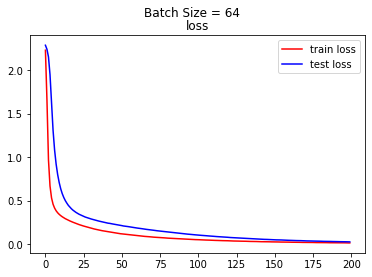

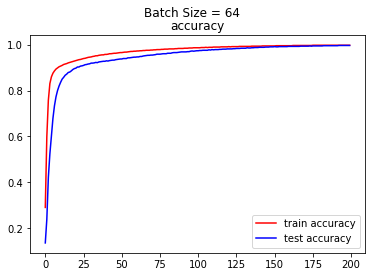

In [ ]:
# Plot Batch Size 64
plt.suptitle("Batch Size = {}".format(batch_sizes[1]))
plt.title("loss")
plt.plot(training_loss_list[1], c = 'red', label = 'train loss')
plt.plot(testing_loss_list[1], c = 'blue', label = 'test loss')
plt.legend(loc = 'upper right')
plt.show()

plt.suptitle("Batch Size = {}".format(batch_sizes[1]))
plt.title("accuracy")
plt.plot(training_acc_list[1], c = 'red', label = 'train accuracy')
plt.plot(testing_acc_list[1], c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

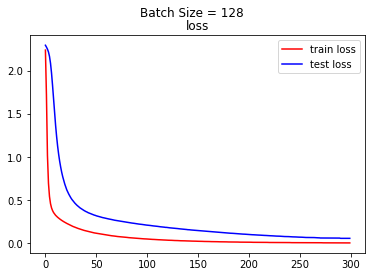

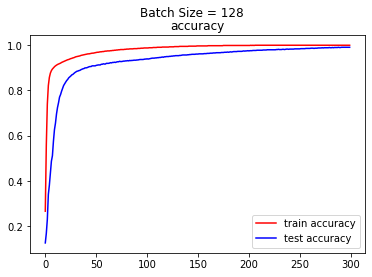

In [54]:
# Plot Batch Size 128
plt.suptitle("Batch Size = {}".format(batch_sizes[2]))
plt.title("loss")
plt.plot(training_loss_list[2], c = 'red', label = 'train loss')
plt.plot(testing_loss_list[2], c = 'blue', label = 'test loss')
plt.legend(loc = 'upper right')
plt.show()

plt.suptitle("Batch Size = {}".format(batch_sizes[2]))
plt.title("accuracy")
plt.plot(training_acc_list[2], c = 'red', label = 'train accuracy')
plt.plot(testing_acc_list[2], c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

# 7. Output

<hr>

1.Plot the training and testing losses with a batch size of 32 [4pt]

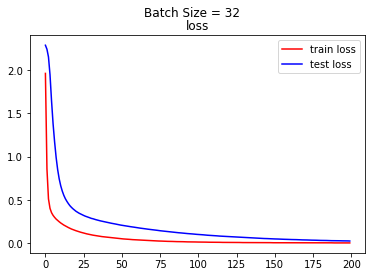

In [55]:
# Plot Batch Size 32
plt.suptitle("Batch Size = {}".format(batch_sizes[0]))
plt.title("loss")
plt.plot(training_loss_list[0], c = 'red', label = 'train loss')
plt.plot(testing_loss_list[0], c = 'blue', label = 'test loss')
plt.legend(loc = 'upper right')
plt.show()

2.Plot the training and testing accuracies with a batch size of 32 [4pt]

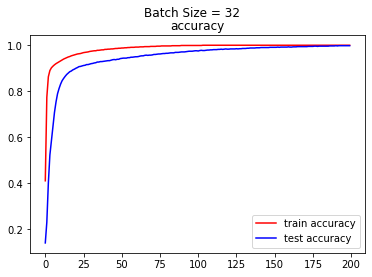

In [56]:
plt.suptitle("Batch Size = {}".format(batch_sizes[0]))
plt.title("accuracy")
plt.plot(training_acc_list[0], c = 'red', label = 'train accuracy')
plt.plot(testing_acc_list[0], c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

3.Plot the training and testing losses with a batch size of 64 [4pt]

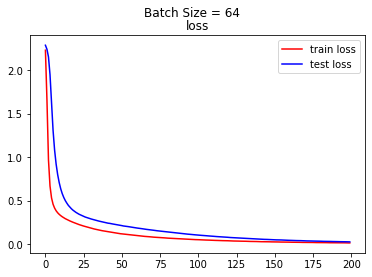

In [57]:
# Plot Batch Size 64
plt.suptitle("Batch Size = {}".format(batch_sizes[1]))
plt.title("loss")
plt.plot(training_loss_list[1], c = 'red', label = 'train loss')
plt.plot(testing_loss_list[1], c = 'blue', label = 'test loss')
plt.legend(loc = 'upper right')
plt.show()

4.Plot the training and testing accuracies with a batch size of 64 [4pt]

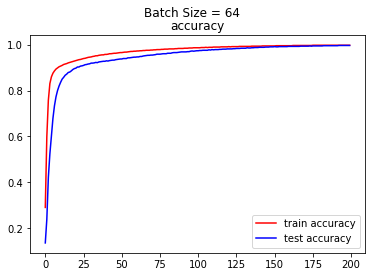

In [58]:
plt.suptitle("Batch Size = {}".format(batch_sizes[1]))
plt.title("accuracy")
plt.plot(training_acc_list[1], c = 'red', label = 'train accuracy')
plt.plot(testing_acc_list[1], c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

5.Plot the training and testing losses with a batch size of 128 [4pt]

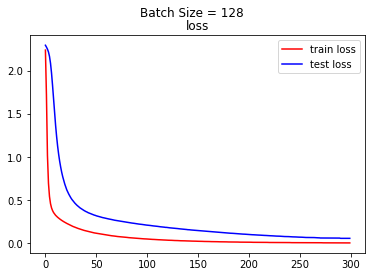

In [59]:
# Plot Batch Size 128
plt.suptitle("Batch Size = {}".format(batch_sizes[2]))
plt.title("loss")
plt.plot(training_loss_list[2], c = 'red', label = 'train loss')
plt.plot(testing_loss_list[2], c = 'blue', label = 'test loss')
plt.legend(loc = 'upper right')
plt.show()

6.Plot the training and testing accuracies with a batch size of 128 [4pt]

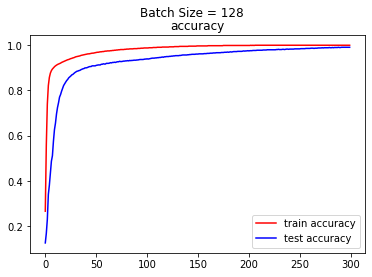

In [60]:
plt.suptitle("Batch Size = {}".format(batch_sizes[2]))
plt.title("accuracy")
plt.plot(training_acc_list[2], c = 'red', label = 'train accuracy')
plt.plot(testing_acc_list[2], c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

7.Print the loss at convergence with different mini-batch sizes [3pt]

In [68]:
data1 = {'32' : [training_loss_list[0][-1], testing_loss_list[0][-1]],
         '64' : [training_loss_list[1][-1], testing_loss_list[1][-1]],
         '128' : [training_loss_list[2][-1], testing_loss_list[2][-1]]}
index1 = ['training loss', 'testing loss']
frame1 = DataFrame(data1, index = index1)
frame1.columns.name = 'mini-batch size'
frame1

mini-batch size,32,64,128
training loss,0.002,0.012,0.004
testing loss,0.024,0.024,0.057


8.Print the accuracy at convergence with different mini-batch sizes [3pt]

In [69]:
data2 = {'32' : [training_acc_list[0][-1], testing_acc_list[0][-1]],
         '64' : [training_acc_list[1][-1], testing_acc_list[1][-1]],
         '128' : [training_acc_list[2][-1], testing_acc_list[2][-1]]}
index2 = ['training accuracy', 'testing accuracy']
frame2 = DataFrame(data2, index = index2)
frame2.columns.name = 'mini-batch size'
frame2

mini-batch size,32,64,128
training accuracy,0.999,0.998,0.999
testing accuracy,0.997,0.997,0.990
